In [2]:
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
binance_df = pd.read_csv('../../data/BTCUSDT/csv/binance_arbitrage.csv')
bybit_df = pd.read_csv('../../data/BTCUSDT/csv/bybit_arbitrage.csv')
kucoin_df = pd.read_csv('../../data/BTCUSDT/csv/kuCoin_arbitrage.csv')
okx_df = pd.read_csv('../../data/BTCUSDT/csv/okx_arbitrage.csv')

In [ ]:
binance_df = pd.read_csv('../data/BTCUSDT/csv/binance_arbitrage.csv')
bybit_df = pd.read_csv('../../data/BTCUSDT/csv/bybit_arbitrage.csv')
kucoin_df = pd.read_csv('../../data/BTCUSDT/csv/kuCoin_arbitrage.csv')
okx_df = pd.read_csv('../../data/BTCUSDT/csv/okx_arbitrage.csv')

In [5]:
#Change time column to datetime
binance_df['time'] = pd.to_datetime(binance_df['time'])
bybit_df['time'] = pd.to_datetime(bybit_df['time'])
kucoin_df['time'] = pd.to_datetime(kucoin_df['time'])
okx_df['time'] = pd.to_datetime(okx_df['time'])

In [3]:
# Define a function to calculate the volume-weighted price and total quantity
def calculate_vwp_and_qty(df, rounded_to='T'):
    # Create a new column 'volume' that represents the volume of each trade
    df['volume'] = df['price'] * df['qty']
    
    # Group by 'time' rounded down to the nearest second
    grouped = df.groupby(df['time'].dt.floor(rounded_to))
    
    # Calculate the volume-weighted price and total quantity for each group
    vwp = (grouped['volume']).sum() / grouped['qty'].sum()
    total_qty = grouped['qty'].sum()
    
    # Return a DataFrame with the 'time', 'price', and 'quantity' columns
    return pd.DataFrame({'time': vwp.index, 'price': vwp.values, 'qty': total_qty.values})

# Arbitrage index

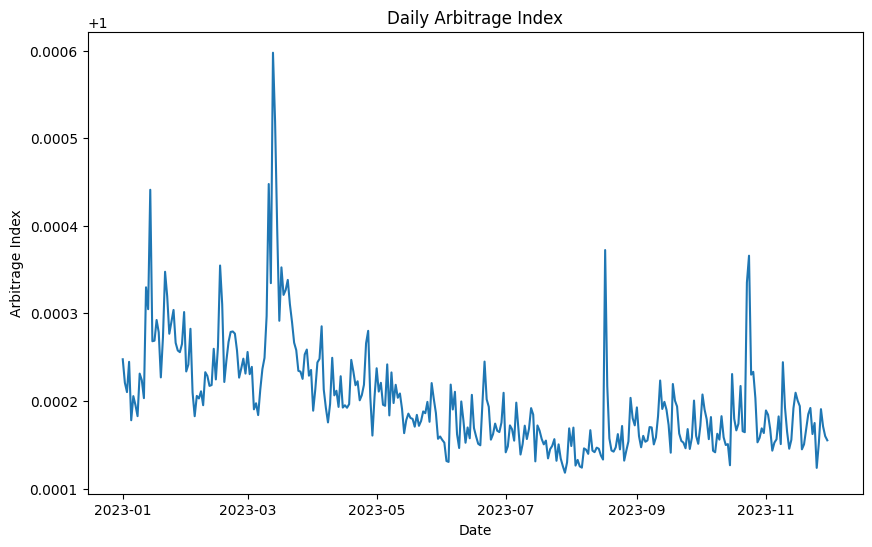

                     price_binance   price_bybit  price_kucoin     price_okx  \
time                                                                           
2023-01-01 00:00:00   16541.227654  16541.338858  16540.031224  16545.429569   
2023-01-01 00:01:00   16540.997707  16540.459493  16540.129818  16544.880253   
2023-01-01 00:02:00   16537.612389  16536.985965  16540.319931  16541.556858   
2023-01-01 00:03:00   16533.746427  16531.564351  16534.510158  16536.618145   
2023-01-01 00:04:00   16531.807771  16531.713318  16529.926954  16536.752898   

                     Arbitrage Index  
time                                  
2023-01-01 00:00:00         1.000326  
2023-01-01 00:01:00         1.000287  
2023-01-01 00:02:00         1.000276  
2023-01-01 00:03:00         1.000306  
2023-01-01 00:04:00         1.000413  


In [7]:
# Calculate the VWAP for each dataset
binance_df_per_minute = calculate_vwp_and_qty(binance_df, 'T')
bybit_df_per_minute = calculate_vwp_and_qty(bybit_df, 'T')
kucoin_df_per_minute = calculate_vwp_and_qty(kucoin_df, 'T')
okx_df_per_minute = calculate_vwp_and_qty(okx_df, 'T')
# Merge the DataFrames on 'time'
vwap_df = binance_df_per_minute[['time', 'price']].merge(bybit_df_per_minute[['time', 'price']], on='time', how='inner', suffixes=('_binance', '_bybit'))
vwap_df = vwap_df.merge(kucoin_df_per_minute[['time', 'price']], on='time', how='inner', suffixes=('', '_kucoin'))
vwap_df = vwap_df.merge(okx_df_per_minute[['time', 'price']], on='time', how='inner', suffixes=('_kucoin', '_okx'))

vwap_df['Arbitrage Index'] = vwap_df[['price_binance', 'price_bybit', 'price_kucoin', 'price_okx']].apply(lambda row: row.max() / row.min(), axis=1)
vwap_df.set_index('time', inplace=True)
daily_arbitrage_index = vwap_df['Arbitrage Index'].resample('D').mean()

# Plot the daily arbitrage index
plt.figure(figsize=(10,6))
plt.plot(daily_arbitrage_index.index, daily_arbitrage_index.values)

plt.title('Daily Arbitrage Index')
plt.xlabel('Date')
plt.ylabel('Arbitrage Index')

plt.show()
# Print the first few rows of the DataFrame
print(vwap_df.head())

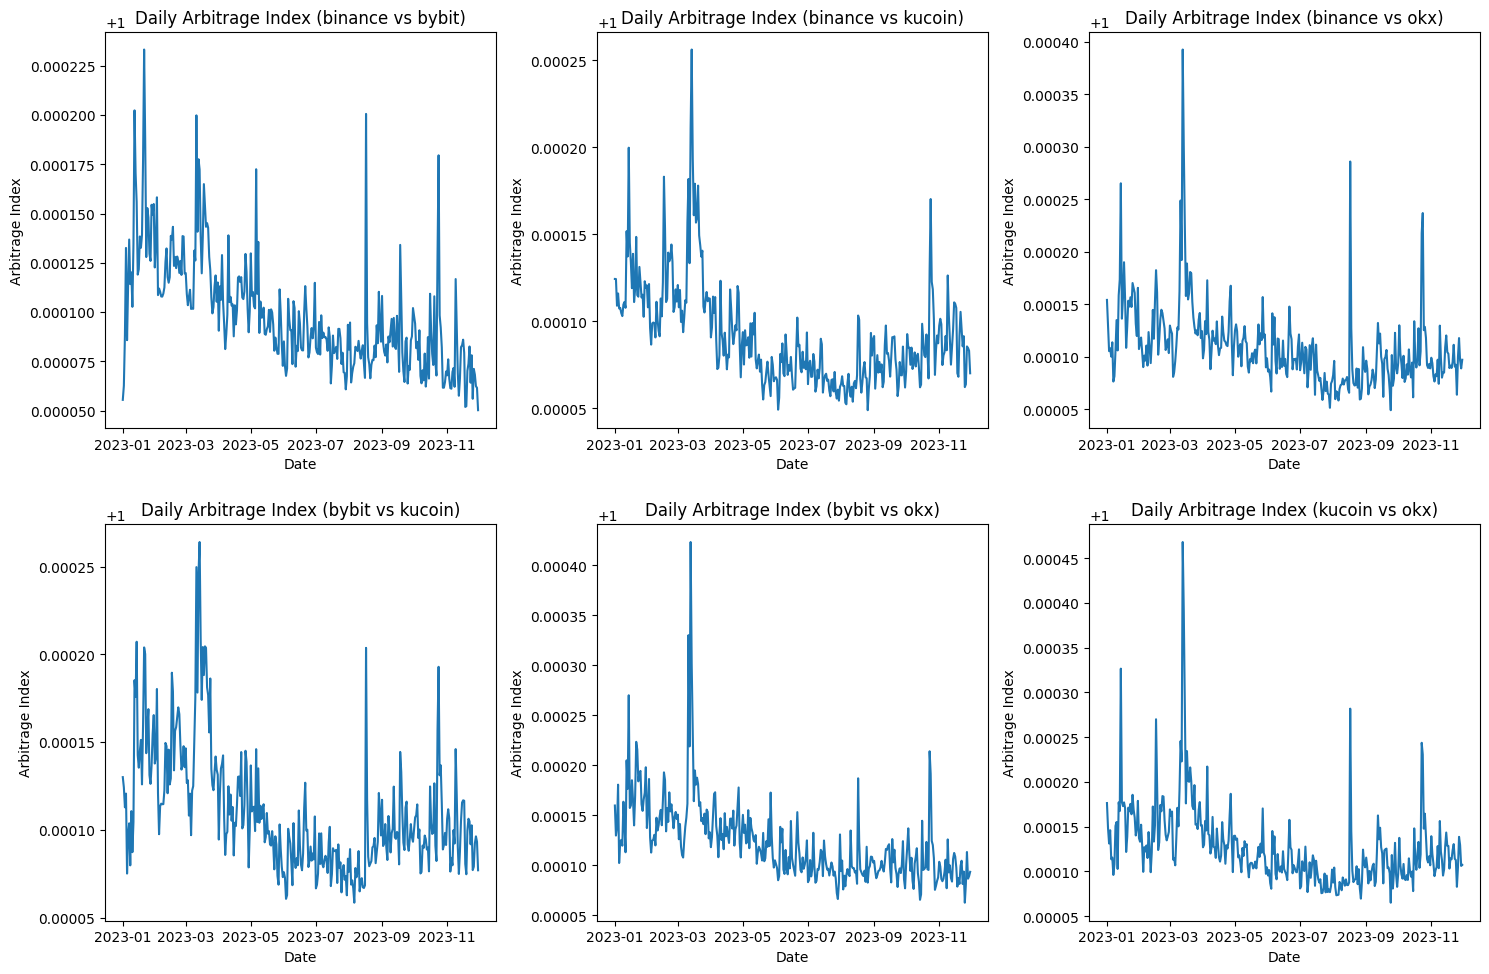

In [8]:
import itertools
import matplotlib.pyplot as plt

# Define a function to calculate the daily arbitrage index for a pair of exchanges
def calculate_daily_arbitrage_index(df1, df2, exchange1, exchange2):
    # Merge the DataFrames on 'time'
    vwap_df = df1[['time', 'price']].merge(df2[['time', 'price']], on='time', how='inner', suffixes=(f'_{exchange1}', f'_{exchange2}'))
    
    # Calculate the arbitrage index for each row
    vwap_df['Arbitrage Index'] = vwap_df[[f'price_{exchange1}', f'price_{exchange2}']].apply(lambda row: row.max() / row.min(), axis=1)
    
    # Set 'time' as the index
    vwap_df.set_index('time', inplace=True)
    
    # Group by day and calculate the mean of the 'Arbitrage Index' column
    daily_arbitrage_index = vwap_df['Arbitrage Index'].resample('D').mean()
    
    return daily_arbitrage_index

# List of exchanges and their corresponding DataFrames
exchanges = [('binance', binance_df_per_minute), ('bybit', bybit_df_per_minute), ('kucoin', kucoin_df_per_minute), ('okx', okx_df_per_minute)]

# Create a 2x3 subplot
fig, axs = plt.subplots(2, 3, figsize=(15, 10))

# Calculate and plot the daily arbitrage index for each pair of exchanges
# Calculate and plot the daily arbitrage index for each pair of exchanges
for ax, ((exchange1, df1), (exchange2, df2)) in zip(axs.flatten(), itertools.combinations(exchanges, 2)):
    daily_arbitrage_index = calculate_daily_arbitrage_index(df1, df2, exchange1, exchange2)
    ax.plot(daily_arbitrage_index.index, daily_arbitrage_index.values)
    ax.set_title(f'Daily Arbitrage Index ({exchange1} vs {exchange2})')
    ax.set_xlabel('Date')
    ax.set_ylabel('Arbitrage Index')

# Adjust the layout
plt.tight_layout()

# Show the plot
plt.show()

# Triangular Arbitrage Profit

In [3]:
#Load BTCUSDT data

btc_binance_df = pd.read_csv('../data/BTCUSDT/csv/binance_arbitrage.csv')
btc_bybit_df = pd.read_csv('../data/BTCUSDT/csv/bybit_arbitrage.csv')
btc_kucoin_df = pd.read_csv('../data/BTCUSDT/csv/kuCoin_arbitrage.csv')
btc_okx_df = pd.read_csv('../data/BTCUSDT/csv/okx_arbitrage.csv')

#load SOLUSDT data

sol_binance_df = pd.read_csv('../data/SOLUSDT/csv/binance_arbitrage.csv')
sol_bybit_df = pd.read_csv('../data/SOLUSDT/csv/bybit_arbitrage.csv')
sol_kucoin_df = pd.read_csv('../data/SOLUSDT/csv/kuCoin_arbitrage.csv')
sol_okx_df = pd.read_csv('../data/SOLUSDT/csv/okx_arbitrage.csv')

#load SOLBTC data

solbtc_binance_df = pd.read_csv('../data/SOLBTC/csv/binance_arbitrage.csv')

FileNotFoundError: [Errno 2] No such file or directory: '../data/BTCUSDT/csv/binance_arbitrage.csv'

In [11]:
btc_merged_df = pd.merge(btc_binance_df, btc_bybit_df, on='time', how='outer', suffixes=('_binance', '_bybit'))
btc_merged_df = pd.merge(btc_merged_df, btc_kucoin_df, on='time', how='outer', suffixes=('', '_kucoin'))
btc_merged_df = pd.merge(btc_merged_df, btc_okx_df, on='time', how='outer', suffixes=('_kucoin', '_okx'))

# Merge SOLUSDT data
sol_merged_df = pd.merge(sol_binance_df, sol_bybit_df, on='time', how='outer', suffixes=('_binance', '_bybit'))
sol_merged_df = pd.merge(sol_merged_df, sol_kucoin_df, on='time', how='outer', suffixes=('', '_kucoin'))
sol_merged_df = pd.merge(sol_merged_df, sol_okx_df, on='time', how='outer', suffixes=('_kucoin', '_okx'))

In [13]:
#save both dataframes to csv
btc_merged_df.to_csv('../../data/BTCUSDT/csv/btc_merged.csv', index=False)
sol_merged_df.to_csv('../../data/SOLUSDT/csv/sol_merged.csv', index=False)

In [11]:
#read both dataframes from csv
btc_merged_df = pd.read_csv('../antoine/btc_merged.csv')
sol_merged_df = pd.read_csv('../antoine/sol_merged.csv')
solbtc_binance_df = pd.read_csv('../antoine/binance_arbitrage.csv')

In [12]:
solbtc_binance_df = solbtc_binance_df[solbtc_binance_df['time'].isin(btc_merged_df['time']) & solbtc_binance_df['time'].isin(sol_merged_df['time'])]

#delete all rows from btc_merged and sol_merged where they don't have a time value in solbtc_binance_df
btc_merged_df = btc_merged_df[btc_merged_df['time'].isin(solbtc_binance_df['time'])]
sol_merged_df = sol_merged_df[sol_merged_df['time'].isin(solbtc_binance_df['time'])]

# Calculate the standard deviation of the prices across the exchanges for each time
btc_merged_df['std_dev'] = btc_merged_df[['price_binance', 'price_bybit', 'price_kucoin', 'price_okx']].std(axis=1)
sol_merged_df['std_dev'] = sol_merged_df[['price_binance', 'price_bybit', 'price_kucoin', 'price_okx']].std(axis=1)

# Sort the DataFrames by the standard deviation in descending order
btc_merged_df = btc_merged_df.sort_values(by='std_dev', ascending=False)
sol_merged_df = sol_merged_df.sort_values(by='std_dev', ascending=False)

# Get the 1000 most volatile times
btc_most_volatile_times = btc_merged_df['time'].head(50000)
sol_most_volatile_times = sol_merged_df['time'].head(50000)

btc_merged_df = btc_merged_df[btc_merged_df['time'].isin(sol_most_volatile_times) | btc_merged_df['time'].isin(btc_most_volatile_times)]
sol_merged_df = sol_merged_df[sol_merged_df['time'].isin(sol_most_volatile_times) | sol_merged_df['time'].isin(btc_most_volatile_times)]
solbtc_binance_df = solbtc_binance_df[solbtc_binance_df['time'].isin(sol_most_volatile_times) | solbtc_binance_df['time'].isin(btc_most_volatile_times)]

In [13]:
# Pre-compute and store the data in dictionaries for quick lookup
btc_lookup = btc_merged_df.set_index('time').to_dict('index')
sol_lookup = sol_merged_df.set_index('time').to_dict('index')

# Calculate the max quantity of BTC for each SOLBTC trade outside the loop
solbtc_binance_df['max_quantity_btc'] = solbtc_binance_df['qty'] * solbtc_binance_df['price']

# Initialize an empty list to store profits
profits = []

# Iterate over solbtc_binance_df without using iterrows()
for time, max_quantity_btc in solbtc_binance_df[['time', 'max_quantity_btc']].values:
    btc_row = btc_lookup.get(time)
    sol_row = sol_lookup.get(time)
    
    if btc_row and sol_row:  # Check if both rows exist
        temp_results = []
        
        for btc_exchange in ['binance', 'bybit', 'kucoin', 'okx']:
            btc_price = btc_row.get(f'price_{btc_exchange}')
            btc_quantity = btc_row.get(f'qty_{btc_exchange}')
            if btc_price and btc_quantity:
                quantity_to_buy = min(max_quantity_btc, btc_quantity)
                enter_price = btc_price * quantity_to_buy
                sol_pre_trade_quantity = quantity_to_buy / solbtc_binance_df.loc[solbtc_binance_df['time'] == time, 'price'].values[0]
                
                for sol_exchange in ['binance', 'bybit', 'kucoin', 'okx']:
                    sol_price = sol_row.get(f'price_{sol_exchange}')
                    sol_quantity = sol_row.get(f'qty_{sol_exchange}')
                    if sol_price and sol_quantity:
                        quantity_to_sell = min(sol_pre_trade_quantity, sol_quantity)
                        exit_price = sol_price * quantity_to_sell
                        profit = (exit_price - enter_price) / enter_price
                        if profit > 0.02:
                            print(time)
                            print(f'Found a profitable trade: {profit:.2%}')
                            temp_results.append(exit_price - enter_price)
        
        if temp_results:
            profits.append(max(temp_results, key=abs))

profit_df = pd.DataFrame(profits, columns=['profit'])

2023-01-04 04:13:08
Found a profitable trade: 2.03%
2023-01-04 04:13:17
Found a profitable trade: 2.01%
2023-01-04 04:13:17
Found a profitable trade: 2.05%
2023-01-04 04:13:21
Found a profitable trade: 2.03%
2023-01-04 04:13:21
Found a profitable trade: 2.12%
2023-01-04 04:13:24
Found a profitable trade: 2.01%
2023-01-04 04:13:25
Found a profitable trade: 2.02%
2023-01-04 04:13:30
Found a profitable trade: 2.03%
2023-01-04 04:13:31
Found a profitable trade: 2.10%
2023-01-04 04:13:31
Found a profitable trade: 2.07%
2023-01-04 04:13:31
Found a profitable trade: 2.04%
2023-01-04 04:13:35
Found a profitable trade: 2.03%
2023-01-04 04:13:37
Found a profitable trade: 2.05%
2023-01-04 04:13:39
Found a profitable trade: 2.06%
2023-01-04 04:13:39
Found a profitable trade: 2.09%
2023-01-04 04:13:39
Found a profitable trade: 2.06%
2023-01-04 04:13:45
Found a profitable trade: 2.08%
2023-01-04 04:13:45
Found a profitable trade: 2.11%
2023-01-04 04:13:51
Found a profitable trade: 2.09%
2023-01-04 0

In [15]:
#number of trades
print('Number of trades:', len(profit_df))
#Sum profit
print('Sum profit:', profit_df['profit'].sum())

Number of trades: 1526
Sum profit: 25791.184800723197
